# Group Cosine Sim LSH
## By: Bo Zhang, Ian Liu, Ian Shyue

First, please study LSH based on cosine similarity:
https://www.bogotobogo.com/Algorithms/Locality_Sensitive_Hashing_LSH_using_Cosine_Distance_Similarity.php

And some additional code with the same implementation:

https://blog.untrod.com/2016/06/simple-similar-products-recommendation-engine-in-python.html

http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html

Second, you need to build a recommendation system using LSH based on cosine similarity: you want to use TF-IDF of documents for cosine similarity.
Required functionality of your recommendation system:

1. Given thousands of articles, you compute the hash value for each article. The 1st document shows how to create 1024 bits hash--this is equivalent to 1024 rows in minhash while in this case, each hash function produces one-bit int and in minhash each hash function/permutation produces 1 regular 4-byte integer.

Cosine Similarity of two TF-IDF vectors (two articles) = Sim(doc1, doc2) = cos( h/b * pi) ; h/b is the probability for hashed bits to match between two docs. So

prob(matching 1 particular bit between 2 doc) = 1 - h/b = 1 - arccos ( cosine_Sim(doc1, doc2) ) / pi

That said, given the cosine similarity of the two documents, you know what's the probability for two hashed bits to match.

Now you want to use the same idea of band and rows for 1024 (or any other number) hashed bits to control TPR/TNR

2. With num_bands, num_rows (i.e. number of bytes*8) as parameters, you save the hash value for each doc in a dictionary, using hash value as the key, and dictionary value is a list with doc ID as list member.

Say you use 1024 bits total and you divide them into 16 bands and each band has 64 bits (or rows) or 8 bytes. An 64-bits integer is your hash value for one particular band.

If you have 16 bands, then you have 16 different dictionaries in total, with each corresponding to one band. Each article will produce 16 hash values (each with 64 bits, from one band) and each hash will be used as the key to the corresponding dictionary. The values for each dictionary are lists of article IDs that hash (64 bits, for that band) into the same "bucket".

3. For query, you are given an article and cosine similarity threshold, you want to return top_n articles that have cosine similarity >= threshold and list them in descending order of similarity with options to print ID only or to print the first N characters from each article. Generally, you compute 16 hash values (assuming you have 16 bands)  candidates are found in 16 dictionaries with these 16 hash values as keys. If no key exists in any of the dictionaries then there is no match. If two dictionaries have matching keys then you combine two lists as candidates. Then you do validation to make sure the similarity is above the threshold.

Alternatively, you can use just one big dictionary. In this case, a hash value 01011101011110111 from band 1 will be converted to a string for dictionary key: "01011101011110111b1" with "b1" indicating band 1, so only band 1 hash can possibly get the same key.

Note: You need to complete the code with the required functionality, and write a full project report explaining what you are doing with the code as an appendix. You need to demonstrate with some example query articles/ query strings. In your report, you need to compute what is your TPR, and FNR for a few sets of typical values of num_bands, num_rows, and similarity thresholds, plus corresponding example queries.

4. Dataset: you can use the 20 newsgroup dataset: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html (Links to an external site.)Links to an external site.

A newsgroup is like an email discussion group based on one specific topic.

Just use the training set:

`from sklearn.datasets import fetch_20newsgroups`

`newsgroups_train = fetch_20newsgroups(subset='train')`

`dir(newsgroups_train)`

  ['DESCR', 'data', 'filenames', 'target', 'target_names']

`len(newsgroups_train.data)`

 11314


Use newsgroups_train.data as a list of documents.
newsgroups_train.target is corresponding list of topics for these documents.
You do not have to use these, but these give you a hint to validate your query: similar docs live under the same subject.

This project is counted as part of final projects.

Each member must submit your group PDF and notebook,
as well as your contribution in the project with all members' siugnatures.




In [ ]:
!apt install -qq enchant
!pip install pyenchant

In [ ]:
from __future__ import division

import gc
import math
import pickle
import random
import re
import time
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from pandas.core.dtypes.dtypes import Ordered
from scipy.integrate import quad as integrate
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm

nltk.download("stopwords")
import string


import enchant
english_dictionary = enchant.Dict("en_US")


newsgroups_train = fetch_20newsgroups(subset="train")

[nltk_data] Downloading package stopwords to /Users/bo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dir(newsgroups_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

## Clean Data

In [ ]:
news_df = pd.DataFrame()
news_df["id"] = newsgroups_train.target
news_df["id"] = list(range(len(newsgroups_train.data)))
news_df["description"] = newsgroups_train.data

news_df

,id,description
0,0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...,...,...
11309,11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310,11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311,11311,From: westes@netcom.com (Will Estes)\nSubject:...
11312,11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...


#1

In [ ]:
# https://www.bogotobogo.com/Algorithms/Locality_Sensitive_Hashing_LSH_using_Cosine_Distance_Similarity.php


def signature_bit(data, planes):
    """
    LSH signature generation using random projection
    Returns the signature bits for two data points.
    The signature bits of the two points are different
    only for the plane that divides the two points.
    """
    sig = 0
    for p in planes:
        sig <<= 1
        if np.dot(data, p) >= 0:
            sig |= 1
    return sig


def bitcount(n: int):
    """
    gets the number of bits set to 1
    """
    count = 0
    while n:
        count += 1
        n = n & (n - 1)
    return count


def length(v: int):
    """
    returns the length of a vector
    """
    return math.sqrt(np.dot(v, v))

In [ ]:
tf = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 1), min_df=0, stop_words="english"
)

_ = tf.fit_transform(news_df["description"])

In [ ]:
def filter_words(word_list: list) -> list:
    """Reomves words from a list of words that are in English stop words and if they are not alphabetical characters.
    Underscore characters are rmoved.

    Parameters
    ----------
    word_list : list

    Returns
    -------
    list
    """

    stop_words = set(stopwords.words("english"))
    filtered_words = [
        word.lower()
        for word in word_list
        if not any(char.isdigit() for char in word) and word.lower() not in stop_words
    ]
    split_words = []
    for word in filtered_words:
        split_words += re.split(r"\s|_", word)
    return split_words


def drop_list(words_list: list) -> list:
    """Removes words from a list of words that are not alphabetical characters.

    Parameters
    ----------
    words_list : list

    Returns
    -------
    list
    """
    words_list = [word.strip() for word in words_list if word.strip() != ""]
    words_list = [word for word in words_list if all(char.isalpha() for char in word)]
    return words_list if len(words_list) > 0 else None


def clean_text(document: str) -> list:
    """Cleans text and returns a list of words in the text sorted alphabetically
    Duplicate words are kept.

    Parameters
    ----------
    document : str

    Returns
    -------
    list
    """
    if isinstance(document, str):
        words = document.split()
    else:
        words = document

    cleaned_words = filter_words(words)
    cleaned_words = drop_list(
        cleaned_words
    )  # strip space and remove nonalphabetical characters
    # if english_dictionary is not None: cleaned_words = [i for i in cleaned_words if english_dictionary.check(i) is True]
    return cleaned_words

In [ ]:
unique_words = tf.vocabulary_.keys()  # unique words in all documents
unique_filtered_words = sorted(
    list(set(clean_text(unique_words)))
)  # unique words in all documents after filtering

print(len(unique_words), len(unique_filtered_words))

30488


In [ ]:
with open("/Users/bo/Desktop/Data Mining/unique_filtered_words.pkl", "rb") as fp:
    unique_filtered_words = pickle.load(fp)
    unique_filtered_words = sorted(unique_filtered_words)

In [ ]:
word_to_index_mapping = {
    word: index for index, word in enumerate(unique_filtered_words)
}
index_to_word_mapping = {
    index: word for index, word in enumerate(unique_filtered_words)
}

with open("index_to_word_mapping.pkl", "wb") as fp:
    pickle.dump(index_to_word_mapping, fp)

with open("word_to_index_mapping.pkl", "wb") as fp:
    pickle.dump(word_to_index_mapping, fp)

In [ ]:
def tf_of_doc(doc: str, unique_word_list: list) -> dict:
    """Generates TF for a given string.

    Parameters
    ----------
    doc : str
        Document to extract TF from.
    unique_word_list : list
        List of unique words.
        If a word in the document is not found in the unique_word_list,
        it is ignored and not returned in the final dictionary.

    Returns
    -------
    dict
        Dictionary of key=word, value=count
    """
    counts = dict()
    words = clean_text(
        doc
    )  # Ensure that all words are lowercase and formatted correctly
    if unique_word_list is None:
        unique_word_list = set(words.copy())

    if words is None: return dict()
    for word in words:
        if word not in unique_word_list:
            continue
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts


def tf_of_docs(
    docs: list,
    unique_word_list: list,
    matrix_bool=True,
    get_idf_bool=False,
    get_df_bool: bool = False,
    word_to_index_mapper: dict = None,
):
    """_summary_

    Parameters
    ----------
    docs : list
        List of strings to calculate TF for.
    unique_word_list : list
        List of unique words to calculate TF for. If a word in a document is not in this list, it is ignored.
    matrix_bool : bool, optional
        Whether or not to generate the TF matrix as a Numpy array or Pandas DataFrame., by default True
        Note: Generating the TF matrix as a Pandas DataFrame has not been tested yet. There may be errors.
    get_idf_bool : bool, optional
        Whether or not to output the IDF dictionary, by default False
    get_df_bool : bool, optional
        Whether or not to get the DF dictionary, by default False
    word_to_index_mapper : dict, optional
        Whether or not to use a default word_to_index mapper, by default None

    Returns
    -------
    _type_
        _description_
    """

    num_of_doc = len(docs)
    if word_to_index_mapper is None:
        word_to_index_mapper = {
            word: index for index, word in enumerate(unique_word_list)
        }

    if not matrix_bool:
        tf_matrix = pd.DataFrame(
            columns=unique_word_list, index=list(range(num_of_doc)), dtype="int64"
        )
        tf_matrix = tf_matrix.fillna(0.0)
    else:
        # Create a TF*IDF matrix where columns are words and rows are documents
        X = np.zeros(len(unique_word_list))
        tf_matrix = np.vstack([X] * num_of_doc)

    if get_idf_bool is True or get_df_bool is True:
        DF_dict = defaultdict(lambda: 0) #Document frequency counter

    for doc_indx, doc in enumerate(docs):
        tf_dict = tf_of_doc(doc, unique_word_list)
        for vocab in tf_dict.keys():
            word_indx = word_to_index_mapper[vocab]

            if matrix_bool is False:
                tf_matrix.loc[doc_indx, vocab] = tf_dict.get(vocab)
            else:
                tf_matrix[doc_indx, word_indx] = tf_dict.get(vocab)

            if get_idf_bool is True or get_df_bool is True:
                DF_dict[word_indx] += 1
                DF_dict[vocab] += 1

        gc.collect()  # Garbage collection

    if get_idf_bool is True or get_df_bool is True:
        IDF_dict = DF_dict.copy()
        for key, _ in IDF_dict.items():
            IDF_dict[key] = math.log2(num_of_doc / IDF_dict.get(key)) #Compute IDF from DF

            #convert defaultdict to dict so that the dictionary can be pickled
            DF_dict = dict(DF_dict)
            IDF_dict = dict(IDF_dict)

        if get_df_bool is True and get_idf_bool is True:
            return tf_matrix, IDF_dict, DF_dict
        elif get_idf_bool is True:
            return tf_matrix, IDF_dict
        else:
            return tf_matrix, DF_dict

    return tf_matrix

In [ ]:
tf_matrix, IDF_dict, DF_dict = tf_of_docs(docs =news_df['description'],
           unique_word_list = unique_filtered_words,
           matrix_bool=True,
           get_df=True,
           get_idf=True,
           word_to_index_mapper=word_to_index_mapping)


with open('DF_dict.pkl', 'wb') as fp:
    pickle.dump(DF_dict, fp)
with open('tf.pkl', 'wb') as fp:
    pickle.dump(tf_matrix, fp)
with open('IDF_dict.pkl', 'wb') as fp:
    pickle.dump(IDF_dict, fp)

Equal?
False


In [ ]:
tf_idf_matrix = tf_matrix.copy()

for key in sorted([key for key in IDF_dict if isinstance(key, int)]):
    if not isinstance(key, int):
        print(key, " is not int")
        continue
    tf_idf_matrix[:, key] = tf_idf_matrix[:, key] * IDF_dict[key]

with open("tf_idf_matrix.pkl", "wb") as fp:
    pickle.dump(tf_idf_matrix, fp)

In [ ]:
#@title
with open("DF_dict.pkl", "rb") as fp:
    DF_dict = pickle.load(fp)
with open("tf.pkl", "rb") as fp:
    tf_matrix = pickle.load(fp)
with open("IDF_dict.pkl", "rb") as fp:
    IDF_dict = pickle.load(fp)
with open("tf_idf_matrix.pkl", "rb") as fp:
    tf_idf_matrix = pickle.load(fp)

In [ ]:
tf_idf_matrix.shape

(11314, 30488)

In [ ]:
def false_positive_probability(threshold, b, r):
  _prob = lambda t : 1 - (1 - t**float(r))**float(b)
  a, err = integrate(_prob, 0.0, threshold)
  return a


def false_negative_probability(threshold, b, r):
  _prob = lambda t : (1 - t**float(r))**float(b)
  a, err = integrate(_prob, threshold, 1.0)
  return a

In [ ]:
output_error = ''
for i in [0.5, 0.7, 0.9]:
    error = dict()
    for j in [4, 8, 16,32, 64]:
        for k in [8,16,32,128]:
            print(f'{j} bands, Threshold {i}, False positive rate for {k} rows: {false_positive_probability(i, j, k)}', f'False negative rate for {k} rows: {false_negative_probability(i, j, k)}')
            error[(j,k)] = false_positive_probability(i, j, k) + false_negative_probability(i, j, k)

    output_error = output_error + f'min error for {i}: {min(error, key=error.get)} {error[min(error, key=error.get)]}'  + f'max error for {i}:  {max(error, key=error.get)}, {error[max(error, key=error.get)]} \n'
print(output_error)


4 bands, Threshold 0.5, False positive rate for 8 rows: 0.0008653675929177837 False negative rate for 8 rows: 0.27966512992209186
4 bands, Threshold 0.5, False positive rate for 16 rows: 1.7951304881352454e-06 False negative rate for 16 rows: 0.38027782162500207
4 bands, Threshold 0.5, False positive rate for 32 rows: 1.4110941623506033e-11 False negative rate for 32 rows: 0.43761039569211635
4 bands, Threshold 0.5, False positive rate for 128 rows: 0.0 False negative rate for 128 rows: 0.48389825891314203
8 bands, Threshold 0.5, False positive rate for 8 rows: 0.0017236115604108916 False negative rate for 8 rows: 0.221714318496674
8 bands, Threshold 0.5, False positive rate for 16 rows: 3.5902045342038246e-06 False negative rate for 16 rows: 0.34622338439177913
8 bands, Threshold 0.5, False positive rate for 32 rows: 2.8221883247012066e-11 False negative rate for 32 rows: 0.41924818793790725
8 bands, Threshold 0.5, False positive rate for 128 rows: 0.0 False negative rate for 128 rows

In [ ]:
output_error = ''
for i in [0.5, 0.7, 0.9]:
    error = dict()
    for j in [4, 8, 16,32, 64]:
        for k in [8,16,32,128]:
            print(f'{j} bands, Threshold {i}, False positive rate for {k} rows: {false_positive_probability(i, j, k)}',
                  f'False negative rate for {k} rows: {false_negative_probability(i, j, k)}')
            error[(j,k)] = false_positive_probability(i, j, k) + false_negative_probability(i, j, k)

    output_error = output_error + f'min error for {i}: {min(error, key=error.get)} {error[min(error, key=error.get)]}'  + f'max error for {i}:  {max(error, key=error.get)}, {error[max(error, key=error.get)]} \n'
print(output_error)

4 bands, Threshold 0.5, False positive rate for 8 rows: 0.0008653675929177837 False negative rate for 8 rows: 0.27966512992209186
4 bands, Threshold 0.5, False positive rate for 16 rows: 1.7951304881352454e-06 False negative rate for 16 rows: 0.38027782162500207
4 bands, Threshold 0.5, False positive rate for 32 rows: 1.4110941623506033e-11 False negative rate for 32 rows: 0.43761039569211635
4 bands, Threshold 0.5, False positive rate for 128 rows: 0.0 False negative rate for 128 rows: 0.48389825891314203
8 bands, Threshold 0.5, False positive rate for 8 rows: 0.0017236115604108916 False negative rate for 8 rows: 0.221714318496674
8 bands, Threshold 0.5, False positive rate for 16 rows: 3.5902045342038246e-06 False negative rate for 16 rows: 0.34622338439177913
8 bands, Threshold 0.5, False positive rate for 32 rows: 2.8221883247012066e-11 False negative rate for 32 rows: 0.41924818793790725
8 bands, Threshold 0.5, False positive rate for 128 rows: 0.0 False negative rate for 128 rows

In [ ]:
def h(s, r, b):
    return 1 - np.power(1 - np.power(s, r), b)


def graph(thresh, r, b):
    x = np.linspace(0, 1, 1000)
    y = h(x, r, b)
    y_line = np.linspace(0.0, 1.0, 100)
    x_line = np.full_like(y_line, thresh)

    fn = false_negative_probability(thresh, b, r)
    fp = false_positive_probability(thresh, b, r)

    fig, ax = plt.subplots()
    plt.plot(x, y, label=f"r={r}, b={b}")
    plt.plot(x_line, y_line, color="red")
    plt.fill_between(
        x, y, 0, where=(x <= thresh), interpolate=True, facecolor="lightgreen"
    )
    plt.fill_between(
        x, y, 1, where=(x >= thresh), interpolate=True, facecolor="lightblue"
    )

    plt.text(
        0.01,
        0.1,
        f"Prob(FN)={fn:0.05f}\nProb(FP)={fp:0.05f}",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5),
    )
    plt.legend()
    ax.set_xlabel("Similarity")
    ax.set_ylabel("Probability of sharing a basket")
    ax.set_title("S-curve Plot")
    plt.show()

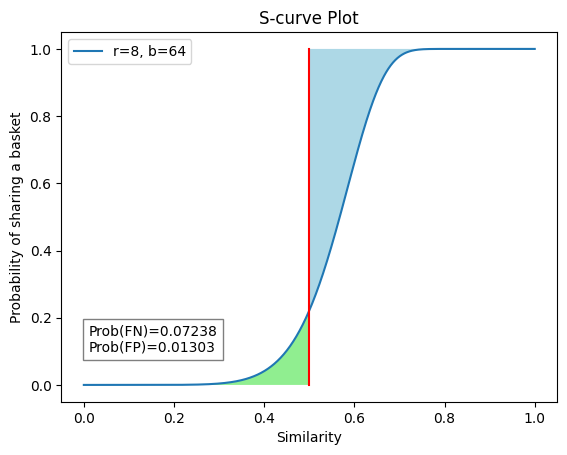

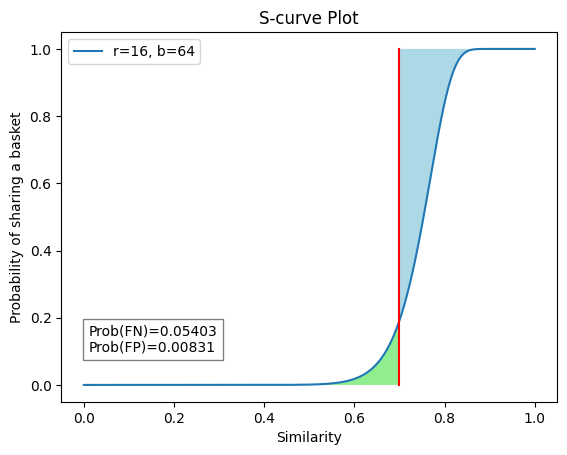

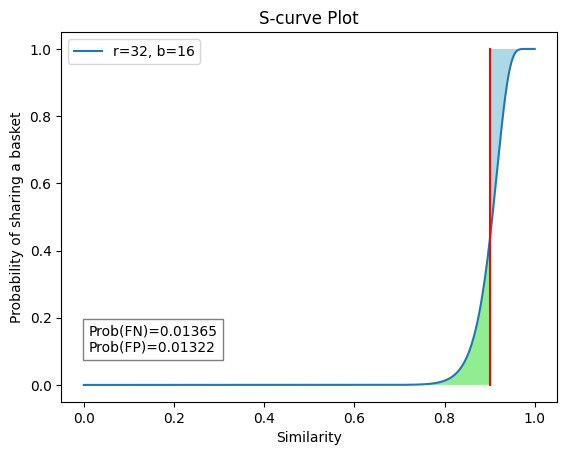

In [ ]:
graph(0.5, 8,64)
graph(0.7, 16,64,)
graph(0.9, 32,16)

In [ ]:
def get_optimal(alpha, beta, threshold, num_hash_bits=1024):

    minimum = 1000000
    optimal_b = []
    optimal_r = []
    for r in range(1, num_hash_bits+1):
        for b in range(1, num_hash_bits+1):
          if r*b <= num_hash_bits:
              err = false_negative_probability(threshold, r, b)*alpha + false_positive_probability(threshold, r, b)*beta
              if err <= minimum:
                minimum = err
                optimal_b = b
                optimal_r = r

    return optimal_b, optimal_r, minimum

# 2 (Ian Liu)

In [ ]:
def get_hash_val(tf_idf_vector, ref_planes) -> int:
    """Returns hash value for a given ref_plane and TF_IDF vector.
    The hash value returned here is not in binary format, if you woud like to use binary format,
    then you should use the bin function like bin(sig). (The signatures should be the same regardless if it's in binary format or not.)


    Parameters
    ----------
    tf_idf_vector : list or np.ndarray
        Dimension should be 1xn
    ref_planes: list or np.ndarray


    Returns
    -------
    int
    """
    # signature bits for two data points
    sig = signature_bit(tf_idf_vector, ref_planes)
    return sig

In [ ]:
def save_hash_value(tf_idf_matrix: np.ndarray, num_bands: int, num_rows: int, save_ref_plane=True):
    """_summary_

    Parameters
    ----------
    tf_idf_matrix : np.ndarray
    num_bands : int
    num_rows : int
    save_ref_plane : bool, optional
        Whether or not to save the ref planes in a dictionary, by default True

    Returns
    -------
    _type_
        _description_
    """
    hashed_dictionaries = []
    if save_ref_plane:
        all_ref_planes = []
    for _ in range(num_bands):
        new_dict = dict()

        # reference planes as many as bits (= signature bits)
        ref_planes = np.random.randn(num_rows, tf_idf_matrix.shape[1])
        if save_ref_plane:
            all_ref_planes.append(ref_planes)

        for doc_id, doc_vector in enumerate(tf_idf_matrix):
            hash_val = get_hash_val(doc_vector, ref_planes=ref_planes)

            if new_dict.get(hash_val) is None:
                new_dict[hash_val] = [doc_id]
            else:
                new_dict[hash_val].append(doc_id)
        hashed_dictionaries.append(new_dict)

    if not save_ref_plane:
        return hashed_dictionaries
    return hashed_dictionaries, all_ref_planes

In [ ]:
all_lsh_buckets = []
all_ref_planes = []
for i in [16,64]:
    for j in tqdm([8,16,32, 64, 128]):
        lsh_buckets, ref_planes = save_hash_value(tf_idf_matrix, num_bands= i, num_rows= j)
        all_lsh_buckets.append(lsh_buckets)
        all_ref_planes.append(ref_planes)

        with open(f'{i}bands{j}rows_lsh_buckets.pkl', 'wb') as fp:
            pickle.dump(lsh_buckets, fp)
        with open(f'{i}bands{j}rows_ref_planes.pkl', 'wb') as fp:
            pickle.dump(ref_planes, fp)

In [ ]:
#@title
with open('all_lsh_buckets.pkl', 'wb') as fp:
    pickle.dump(all_lsh_buckets, fp)
with open('all_ref_planes.pkl', 'wb') as fp:
    pickle.dump(all_ref_planes, fp)

# 3 Ian Shyue

3. For query, you are given an article and cosine similarity threshold, you want to return top_n articles that have cosine similarity >= threshold and list them in descending order of similarity with options to print ID only or to print the first N characters from each article. Generally, you compute 16 hash values (assuming you have 16 bands)  candidates are found in 16 dictionaries with these 16 hash values as keys. If no key exists in any of the dictionaries then there is no match. If two dictionaries have matching keys then you combine two lists as candidates. Then you do validation to make sure the similarity is above the threshold.

Alternatively, you can use just one big dictionary. In this case, a hash value 01011101011110111 from band 1 will be converted to a string for dictionary key: "01011101011110111b1" with "b1" indicating band 1, so only band 1 hash can possibly get the same key.

Note: You need to complete the code with the required functionality, and write a full project report explaining what you are doing with the code as an appendix. You need to demonstrate with some example query articles/ query strings. In your report, you need to compute what is your TPR, and FNR for a few sets of typical values of num_bands, num_rows, and similarity thresholds, plus corresponding example queries.

In [ ]:
#@title
with open('/content/gdrive/MyDrive/Data Mining Group Project Cosine LSH/tf.pkl', 'rb') as fp:
    tf_matrix = pickle.load(fp)
with open('/content/gdrive/Shareddrives/FTCM/Data Mining/Ian Liu HW + Projects/Data Mining Group Project Cosine LSH/lsh_buckets.pkl', 'rb') as fp:
    lsh_buckets = pickle.load(fp)
with open('/content/gdrive/Shareddrives/FTCM/Data Mining/Ian Liu HW + Projects/Data Mining Group Project Cosine LSH/idf_dict.pkl', 'rb') as fp:
    IDF_dict = pickle.load(fp)
with open('/content/gdrive/Shareddrives/FTCM/Data Mining/Ian Liu HW + Projects/Data Mining Group Project Cosine LSH/df_dict.pkl', 'rb') as fp:
    DF_dict = pickle.load(fp)


# READ ALL VARIABLES

with open('/content/gdrive/MyDrive/Data Mining Group Project Cosine LSH/lsh_buckets.pkl', 'rb') as fp:
    lsh_buckets = pickle.load(fp)
with open('/content/gdrive/MyDrive/Data Mining Group Project Cosine LSH/idf_dict.pkl', 'rb') as fp:
    IDF_dict = pickle.load(fp)
with open('/content/gdrive/MyDrive/Data Mining Group Project Cosine LSH/df_dict.pkl', 'rb') as fp:
    DF_dict = pickle.load(fp)


## THIS MIGHT NOT BE NECESSARY, MIGHT WASTE RAM
# with open('/content/gdrive/MyDrive/Data Mining Group Project Cosine LSH/tf_idf_matrix.pkl', 'rb') as fp:
#     final_tf_idf_matrix = pickle.load(fp)

In [ ]:
def top_n(
    document: str, n: int, similarity_threshold: float,
    planes: list, unique_word_list: list, lsh_buckets: list,
    return_all_bool: bool = False, print_first_n_char: int = 0,):
    """
    Takes a document and cleans it using clean()

    Remove any word thats not in unique_word_list

    Sorts the cleaned document according to unique_word_list alphabetically

    Computes TF-IDF on the cleaned document

    Computes hash using planes

    Select candidate documents

    Find similarity
    """

    TF_IDF = tf_of_docs(
        [document], unique_word_list, word_to_index_mapper=word_to_index_mapping
    )

    for key in sorted([key for key in IDF_dict if isinstance(key, int)]):
        if not isinstance(key, int):
            print(key, " is not int")
            continue
        TF_IDF[:, key] = TF_IDF[:, key] * IDF_dict[key]

    similar_doc_list = list()

    rows = len(planes[0])

    for plane in planes:
        hashed = signature_bit(TF_IDF, plane)
        for band in lsh_buckets:  # dictionary {hash: docID's}
            if hashed in band.keys():
                for doc in band[hashed]:
                    similar_doc_list.append(doc)

    similar_doc_list = set(similar_doc_list)

    tf_vectors_dict = {i: tf_idf_matrix[int(i), :] for i in similar_doc_list}

    ref_planes = np.random.randn(rows, TF_IDF.shape[1])

    cosine_hash_dict = dict()

    bits = len(ref_planes)

    # rehash the candidate list and new document then compute cos sim
    sig1 = signature_bit(TF_IDF, ref_planes)
    for key, doc_vector in tf_vectors_dict.items():
        sig2 = signature_bit(doc_vector, ref_planes)
        cosine_hash_dict[key] = 1 - bitcount(sig1 ^ sig2) / bits

    if return_all_bool: all_results = cosine_hash_dict.copy()
    keys = [k for k, v in cosine_hash_dict.items() if v < similarity_threshold]
    for x in keys:
        similar_doc_list.remove(x)
        del cosine_hash_dict[x]

    ids = set(tf_vectors_dict.keys()).intersection(
        set(cosine_hash_dict.keys())
    )  # only gets keys of vectors that passed the similarity threshold test
    top_n_doc_ids = sorted(
        ids, key=lambda ele: cosine_hash_dict.get(ele), reverse=True
    )[:n]
    top_n_doc_similarities = [cosine_hash_dict[doc_id] for doc_id in top_n_doc_ids]

    if print_first_n_char > 0:
        print(f"First {print_first_n_char} characters of nput document:", document[:print_first_n_char])
        print(f"First {print_first_n_char} characters of candidate documents: ")
        for top_n_doc_id in top_n_doc_ids:
            print(f'Doc ID: {top_n_doc_id}', newsgroups_train.data[top_n_doc_id][:print_first_n_char])

    if return_all_bool: return top_n_doc_ids, top_n_doc_similarities, all_results
    else: return top_n_doc_ids, top_n_doc_similarities



In [ ]:
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes"),
)
news_test_df = pd.DataFrame()
news_test_df["id"] = newsgroups_test.target
news_test_df["id"] = list(range(len(newsgroups_test.data)))
news_test_df["description"] = newsgroups_test.data

news_test_df

,id,description
0,0,I am a little confused on all of the models of...
1,1,I'm not familiar at all with the format of the...
2,2,"\nIn a word, yes.\n"
3,3,\nThey were attacking the Iraqis to drive them...
4,4,\nI've just spent two solid months arguing tha...
...,...,...
7527,7527,"\n Henry, if I read you correctly, you may b..."
7528,7528,"about\nthem on\n\nActually, I thought Macs wer..."
7529,7529,"I sent a version of this post out a while ago,..."
7530,7530,I have this kit which includes the following :...


In [ ]:
top_n_test, top_n_test_sim,test_result_thing = top_n(
    news_test_df["description"][0],
    10,
    0.7,
    all_ref_planes[0],
    unique_filtered_words,
    all_lsh_buckets[0],
    print_first_n_char=20,
    return_all_bool=True
)

First 20 characters of nput document: I am a little confus
First 20 characters of candidate documents: 
Doc ID: 2048 From: mikkot@romulus
Doc ID: 2100 From: surfer@world.s
Doc ID: 8363 From: maynard@ramsey
Doc ID: 366 From: db7n+@andrew.c
Doc ID: 487 From: margoli@watson
Doc ID: 2608 From: jono@mac-ak-24
Doc ID: 8774 From: david@terminus
Doc ID: 650 From: ata@hfsi.hfsi.
Doc ID: 693 From: chen@protostar
Doc ID: 2790 From: oehler@picard.


In [ ]:
test_input_document_category = newsgroups_test.target_names[newsgroups_test.target[0]].split('.')[0]
some_threshold = 0.7
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for result_doc_id in test_result_thing.keys():
    candidate_target = newsgroups_train.target_names[newsgroups_train.target[result_doc_id]].split('.')[0]

    if candidate_target == test_input_document_category:
        if test_result_thing[result_doc_id] >= some_threshold:
            true_positives  += 1
        else:
            false_negatives += 1
    else:
        if test_result_thing[result_doc_id] >= some_threshold:
            false_positives += 1
        else:
            true_negatives += 1


precision = true_positives/ (true_positives+false_positives)
recall = true_positives /(true_positives+false_negatives)
fp_rate = false_positives/(false_positives+true_negatives)
specificity = 1-fp_rate
f1score = 2* (precision*recall)/(precision+recall)
accuracy = (true_positives+true_negatives)/(true_positives+false_negatives+true_negatives+false_positives)

print(len(test_result_thing.keys()))
print(true_positives, true_negatives, false_positives, false_negatives)
print(accuracy, precision, recall, specificity, f1score)


6871
216 4537 890 1228
0.6917479260660748 0.19529837251356238 0.14958448753462603 0.8360051593882439 0.16941176470588235


In [ ]:
N = 1
sim_threshold = 0.7
number_of_articles = 100
results = dict()


for indx, ref_plane in enumerate(all_ref_planes):
    print(
        "row numbers: ", len(ref_plane[0]), "band numbers: ", len(all_lsh_buckets[indx])
    )
    band_num = len(all_lsh_buckets[indx])
    row_num = len(ref_plane[0])

    if results.get(band_num) is None:
        results[band_num] = {}

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    for input_indx, input_document in enumerate(
        news_test_df["description"][:number_of_articles]
    ):
        _, _, all_topn_results = top_n(
            input_document,
            N,
            sim_threshold,
            ref_plane,
            unique_filtered_words,
            all_lsh_buckets[indx],
            return_all_bool=True,
        )
        input_document_category = newsgroups_test.target_names[
            newsgroups_test.target[input_indx]
        ].split(".")[0]

        # all_topn_results takes the format of {docid: similarity}

        for result_doc_id in all_topn_results.keys():
            candidate_target = newsgroups_train.target_names[
                newsgroups_train.target[result_doc_id]
            ].split(".")[0]

            if (
                candidate_target == test_input_document_category
            ):  # The documents are actually in the same category
                if (
                    all_topn_results[result_doc_id] >= sim_threshold
                ):  # The documents were predicted to be in the same category
                    true_positives += 1
                else:  # The documents were predicted to not be in the same category
                    false_negatives += 1
            else:  # the documents are not in the same category
                if (
                    all_topn_results[result_doc_id] >= sim_threshold
                ):  # the docuemnts were predicted to be in the same category
                    false_positives += 1
                else:  # the documents were predicted to not be in the same category
                    true_negatives += 1


    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    if false_positives + true_negatives == 0: fp_rate = 0
    else: fp_rate = false_positives / (false_positives + true_negatives)

    specificity = 1 - fp_rate
    f1score = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / (
        true_positives + false_negatives + true_negatives + false_positives
    )

    results[band_num][row_num] = {
        "precision": precision,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "accuracy": accuracy,
        "recall": recall,
        "fp_rate": fp_rate,
        "f1score": f1score,
        "specificity": specificity,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,

    }


row numbers:  8 band numbers:  16
row numbers:  16 band numbers:  16
row numbers:  32 band numbers:  16
row numbers:  64 band numbers:  16
row numbers:  128 band numbers:  16
row numbers:  8 band numbers:  64
row numbers:  16 band numbers:  64
row numbers:  32 band numbers:  64
row numbers:  64 band numbers:  64
row numbers:  128 band numbers:  64


In [ ]:
print(json.dumps(results, indent=4, sort_keys=True))

{
    "16": {
        "8": {
            "accuracy": 0.7055185124010049,
            "f1score": 0.17414518193454012,
            "false_negatives": 124353,
            "false_positives": 78894,
            "fp_rate": 0.1449181122842595,
            "precision": 0.21360007176818874,
            "recall": 0.14699345598222002,
            "specificity": 0.8550818877157405,
            "true_negatives": 465510,
            "true_positives": 21429
        },
        "16": {
            "accuracy": 0.7636193593640402,
            "f1score": 0.08340888485947416,
            "false_negatives": 882,
            "false_positives": 129,
            "fp_rate": 0.038518960883845925,
            "precision": 0.26285714285714284,
            "recall": 0.04956896551724138,
            "specificity": 0.9614810391161541,
            "true_negatives": 3220,
            "true_positives": 46
        },
        "32": {
            "accuracy": 0.8,
            "f1score": 0.888888888888889,
            "false